# **Đồ án môn học**
## Môn: Lập trình song song ứng dụng
### Lớp CQ2021/21 - Nhóm 05
#### Thành viên:
| Họ và tên             | MSSV |
| :-----------          |     :----:|
| Diệp Đại Thiện Nhân | 18120491  |
| Hoàng Trung Nam  | 21120290 |


# **Tổng quan đồ án**

- Nhóm quyết định thử sức với VGG.

- VGG là một kiến trúc CNN sâu được giới thiệu bởi nhóm VGG (Visual Geometry Group) thuộc Đại học Oxford năm 2014. Kiến trúc này nổi bật bởi việc sử dụng nhiều lớp convolution 3x3 liên tiếp thay vì một lớp convolution lớn (vd: 5x5 hay 7x7), nhằm tăng khả năng học đặc trưng và giữ kích thước receptive field ổn định.

- Hai phiên bản phổ biến:
  - VGG-16: 16 lớp có trọng số (13 conv + 3 FC).
  - VGG-19: 19 lớp có trọng số (16 conv + 3 FC).

- **Input của CIFAR-10** là `32x32x3`, nhỏ hơn rất nhiều so với `224x224x3` của VGG gốc.

Vậy nên, khi áp dụng VGG cho CIFAR-10, ta cần **giảm số lượng layer** hoặc **điều chỉnh input size** như sau:

## **Kiến trúc mô hình cụ thể**

- **Input Layer**  
  - 32×32×3 (RGB)

- **Block 1**  
  - Conv3×3, 64 filters + ReLU  
  - Conv3×3, 64 filters + ReLU  
  - MaxPool 2×2

- **Block 2**  
  - Conv3×3, 128 filters + ReLU  
  - Conv3×3, 128 filters + ReLU  
  - MaxPool 2×2

- **Block 3**  
  - Conv3×3, 256 filters + ReLU  
  - Conv3×3, 256 filters + ReLU  
  - MaxPool 2×2

- **Fully Connected**  
  - FC 512 + ReLU  
  - FC 10 + Softmax

- **Optimization**  
  - Loss: Cross‑Entropy  
  - Optimizer: SGD/Adam  
  - Parallelization: Viết bằng Numpy → tối ưu với Numba (`@cuda.jit`)

Kiến trúc VGG‑like này giữ tinh thần “nhiều conv 3×3” của VGG gốc nhưng thu gọn cho phù hợp với kích thước ảnh 32×32 và dataset CIFAR‑10.

## **Dataset**

- **CIFAR-10**:
  - 60.000 ảnh màu 32×32 thuộc 10 lớp.

  - 50.000 ảnh train, 10.000 ảnh test.

  - Link: https://www.cs.toronto.edu/~kriz/cifar.html

## **Nội dung đã hoàn thành**

## **Cài đặt hàm tuần tự**

### **Ý tưởng**

#### 📥 Input Layer

- Kích thước ảnh: **32 × 32 × 3 (RGB)**  
- Sau mỗi layer, kích thước thay đổi tùy theo padding và pooling.

---

#### 🧠 1. Convolutional Layer (3×3)

**Công thức:**

$$
Y[i,j,cout] = \sum_{u=0}^{2} \sum_{v=0}^{2} \sum_{cin=0}^{C_{in}-1} K[u,v,cin,cout] \cdot X[i+u, j+v, cin]
$$

**Chú thích biến:**
- $ X $ : ảnh đầu vào, kích thước (H, W, Cin)
- $K$: kernel/lọc, kích thước (3, 3, Cin, Cout)
- $Y$: ảnh đầu ra sau convolution, kích thước (H', W', Cout)
- $i, j$: vị trí không gian
- $u, v$: tọa độ trong kernel
- $cin, cout$: chỉ số kênh đầu vào và đầu ra

**Song song hóa:**  
✔ Mỗi phần tử $Y[i,j,cout]$ độc lập → triển khai bằng `@cuda.jit` (Numba)

---

#### ⚡ 2. Activation Layer (ReLU)

**Công thức:**

$$
A[i,j,c] = \max(0, Z[i,j,c])
$$

**Chú thích biến:**
- $Z$ : đầu ra từ convolution
- $A$: đầu ra sau kích hoạt ReLU

**Song song hóa:**  
✔ Mỗi phần tử độc lập → dùng `@vectorize` hoặc `@cuda.jit`

---

#### 🌊 3. Max Pooling Layer (2×2)

**Công thức:**

$$
P[i,j,c] = \max \begin{Bmatrix}
X[2i, 2j, c], & X[2i+1, 2j, c], \\
X[2i, 2j+1, c], & X[2i+1, 2j+1, c]
\end{Bmatrix}
$$

**Chú thích biến:**
- $X$: đầu vào trước pooling
- $P$: đầu ra sau pooling
- $i, j$: vị trí trên ảnh pooling
- $c$ : kênh màu

**Song song hóa:**  
✔ Mỗi vùng pooling độc lập → dùng `@cuda.jit`

---

#### 🧩 4. Fully Connected Layer (FC)

**Công thức:**

$$
y_k = \sum_{d=0}^{D-1} W[d,k] \cdot x_d + b_k
$$

**Chú thích biến:**
- $x$: vector đầu vào đã flatten (sau các conv)
- $W$: ma trận trọng số FC (D, K)
- $b$: bias
- $y$: output vector

**Song song hóa:**  
✔ Mỗi $y_k$ độc lập → dùng `@cuda.jit` hoặc `@njit(parallel=True)`

---

#### 🔥 5. Softmax + Cross-Entropy Loss

**Softmax:**

$$
p_i = \frac{e^{y_i}}{\sum_j e^{y_j}}
$$

**Loss:**

$$
L = -\sum_i t_i \cdot \log(p_i)
$$

**Chú thích biến:**
- $y_i$: giá trị đầu ra từ FC
- $p_i$: xác suất sau softmax
- $t_i$: nhãn thật (one-hot)
- $L$: hàm mất mát

**Song song hóa:**  
✘ Không cần, tính nhẹ, có thể xử lý trên CPU

---

#### 🔁 6. Backpropagation + Weight Update

##### Gradient của Softmax + CrossEntropy:

$$
\frac{\partial L}{\partial y_i} = p_i - t_i
$$

---

##### Gradient của FC:

$$
\frac{\partial L}{\partial W[d,k]} = x_d \cdot \frac{\partial L}{\partial y_k}
\quad ; \quad
\frac{\partial L}{\partial b_k} = \frac{\partial L}{\partial y_k}
$$

**Song song hóa:** ✔ từng phần tử độc lập → `@cuda.jit`

---

##### Gradient của ReLU:

$$
\frac{\partial L}{\partial Z[i,j,c]} = 
\begin{cases}
\frac{\partial L}{\partial A[i,j,c]}, & \text{if } Z[i,j,c] > 0 \\
0, & \text{otherwise}
\end{cases}
$$

---

##### Gradient của Convolution:

$$
\frac{\partial L}{\partial K[u,v,cin,cout]} = \sum_{i,j} \frac{\partial L}{\partial Y[i,j,cout]} \cdot X[i+u,j+v,cin]
$$

$$
\frac{\partial L}{\partial X[i,j,cin]} = \sum_{u,v,cout} \frac{\partial L}{\partial Y[i-u,j-v,cout]} \cdot K[u,v,cin,cout]
$$

**Song song hóa:** ✔ nặng nhất → dùng `@cuda.jit` để tối ưu

---

#### ✅ Tóm tắt khả năng song song hóa

| Lớp              | Cần song song | Ghi chú                                |
|------------------|----------------|----------------------------------------|
| Convolution       | ✅              | Tính toán nặng, phần tử độc lập         |
| ReLU              | ✅              | Mỗi phần tử tính riêng được             |
| Max Pooling       | ✅              | Mỗi vùng pooling độc lập               |
| Fully Connected   | ✅              | Mỗi neuron đầu ra độc lập              |
| Softmax + Loss    | ❌              | Tính nhẹ, xử lý CPU vẫn hiệu quả       |
| Backpropagation   | ✅              | Các đạo hàm có thể tính độc lập        |



### **Chuẩn bị dữ liệu**

In [4]:
import os
import urllib.request
import tarfile

import pickle
import numpy as np

import matplotlib.pyplot as plt
import random
import math
import time

In [ ]:
# Script này tải xuống và giải nén tập dữ liệu CIFAR-10 từ trang web chính thức
def download_cifar10():
    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    filename = 'cifar-10-python.tar.gz'
    folder = 'cifar-10-batches-py'

    if not os.path.exists(filename):
        print("⏬ Downloading CIFAR-10...")
        urllib.request.urlretrieve(url, filename)

    if not os.path.exists(folder):
        print("📦 Extracting CIFAR-10...")
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall()
    print("✅ Done.")

download_cifar10()

⏬ Downloading CIFAR-10...
📦 Extracting CIFAR-10...


C:\Users\WIN 10\AppData\Local\Temp\ipykernel_9612\3000658681.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


✅ Done.


In [5]:
# Load CIFAR-10 dataset
def load_batch(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        images = data[b'data']
        labels = data[b'labels']
        images = images.reshape(-1, 3, 32, 32)  # N x C x H x W
        return images, labels

def load_cifar10_data():
    base_dir = 'cifar-10-batches-py'
    X_train, y_train = [], []

    # Load 5 training batches
    for i in range(1, 6):
        images, labels = load_batch(f'{base_dir}/data_batch_{i}')
        X_train.append(images)
        y_train += labels

    # Load test batch
    X_test, y_test = load_batch(f'{base_dir}/test_batch')

    # Convert to numpy arrays
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_cifar10_data()
print("✅ CIFAR-10 loaded:", X_train.shape, y_train.shape)


✅ CIFAR-10 loaded: (50000, 3, 32, 32) (50000,)


In [4]:
# Đưa giá trị pixel về [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
print("✅ Normalized CIFAR-10 data:", X_train.shape, y_train.shape)
print("✅ Normalized CIFAR-10 test data:", X_test.shape, y_test.shape)

✅ Normalized CIFAR-10 data: (50000, 3, 32, 32) (50000,)
✅ Normalized CIFAR-10 test data: (10000, 3, 32, 32) (10000,)


In [5]:
# Chuyển đổi nhãn thành one-hot encoding
def one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

y_train_oh = one_hot(y_train)
y_test_oh = one_hot(y_test)
print("✅ One-hot encoded CIFAR-10 labels:", y_train_oh.shape)
print("✅ One-hot encoded CIFAR-10 test labels:", y_test_oh.shape)

✅ One-hot encoded CIFAR-10 labels: (50000, 10)
✅ One-hot encoded CIFAR-10 test labels: (10000, 10)


In [6]:
# in các ảnh ngẫu nhiên
def show_random_images(X, y, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        idx = random.randint(0, len(X) - 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx].transpose(1, 2, 0))  # Chuyển đổi từ (C, H, W) sang (H, W, C)
        plt.title(f"Label: {y[idx]}")
        plt.axis('off')
    plt.show()

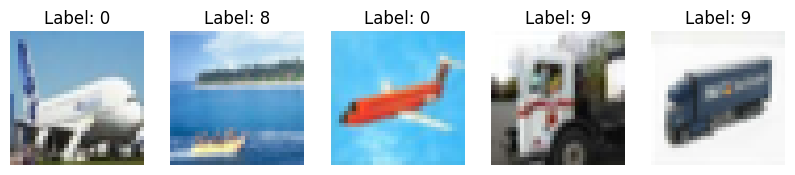

In [20]:
show_random_images(X_train, y_train)

In [7]:
# in cây thư mục hiện tại
def print_directory_tree(path='.'):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")

print("📂 Current directory tree:")
print_directory_tree()

📂 Current directory tree:
./
    .gitignore
    app_group7.ipynb
    cifar-10-python.tar.gz
    Image_Classification.ipynb
    README.md
    .git/
        COMMIT_EDITMSG
        config
        description
        FETCH_HEAD
        HEAD
        index
        ORIG_HEAD
        packed-refs
        hooks/
            applypatch-msg.sample
            commit-msg.sample
            fsmonitor-watchman.sample
            post-update.sample
            pre-applypatch.sample
            pre-commit.sample
            pre-merge-commit.sample
            pre-push.sample
            pre-rebase.sample
            pre-receive.sample
            prepare-commit-msg.sample
            push-to-checkout.sample
            sendemail-validate.sample
            update.sample
        info/
            exclude
        logs/
            HEAD
            refs/
                heads/
                    main
                    nam
                remotes/
                    origin/
                        HEAD

### **Phiên bản được viết bằng python thuần**

#### **Class Conv2D**

In [8]:
def zero_pad(input_data, pad):
        H, W, C = len(input_data), len(input_data[0]), len(input_data[0][0])
        padded = [[[0.0 for _ in range(C)] for _ in range(W + 2 * pad)] for _ in range(H + 2 * pad)]
        
        for i in range(H):
            for j in range(W):
                for c in range(C):
                    padded[i + pad][j + pad][c] = input_data[i][j][c]
        
        return padded

class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=0, stride=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        self.kernels = [[[[random.uniform(-0.1, 0.1)
            for _ in range(out_channels)]
            for _ in range(in_channels)]
            for _ in range(kernel_size)]
            for _ in range(kernel_size)]

    def forward(self, input_data):
        self.input_data = input_data
        pad = self.padding
        stride = self.stride
        k = self.kernel_size
        cin = self.in_channels
        cout = self.out_channels

        input_padded = zero_pad(input_data, pad)
        self.input_padded = input_padded

        H, W, _ = len(input_padded), len(input_padded[0]), len(input_padded[0][0])
        out_h = (H - k) // stride + 1
        out_w = (W - k) // stride + 1

        output = [[[0.0 for _ in range(cout)] for _ in range(out_w)] for _ in range(out_h)]

        for i in range(out_h):
            for j in range(out_w):
                for cout_idx in range(cout):
                    val = 0.0
                    for u in range(k):
                        for v in range(k):
                            for cin_idx in range(cin):
                                x = i * stride + u
                                y = j * stride + v
                                val += input_padded[x][y][cin_idx] * self.kernels[u][v][cin_idx][cout_idx]
                    output[i][j][cout_idx] = val
        return output

    def backward(self, grad_output):
        pad = self.padding
        stride = self.stride
        k = self.kernel_size
        cin = self.in_channels
        cout = self.out_channels
        input_padded = self.input_padded
        H, W, _ = len(input_padded), len(input_padded[0]), len(input_padded[0][0])
        out_h = len(grad_output)
        out_w = len(grad_output[0])

        grad_input_padded = [[[0.0 for _ in range(cin)] for _ in range(W)] for _ in range(H)]
        grad_kernels = [[[[0.0 for _ in range(cout)] for _ in range(cin)] for _ in range(k)] for _ in range(k)]

        for u in range(k):
            for v in range(k):
                for cin_idx in range(cin):
                    for cout_idx in range(cout):
                        grad = 0.0
                        for i in range(out_h):
                            for j in range(out_w):
                                x = i * stride + u
                                y = j * stride + v
                                grad += input_padded[x][y][cin_idx] * grad_output[i][j][cout_idx]
                        grad_kernels[u][v][cin_idx][cout_idx] = grad

        for i in range(H):
            for j in range(W):
                for cin_idx in range(cin):
                    grad = 0.0
                    for u in range(k):
                        for v in range(k):
                            for cout_idx in range(cout):
                                x = i - u
                                y = j - v
                                if 0 <= x // stride < out_h and 0 <= y // stride < out_w:
                                    if x % stride == 0 and y % stride == 0:
                                        grad += grad_output[x // stride][y // stride][cout_idx] * self.kernels[u][v][cin_idx][cout_idx]
                    grad_input_padded[i][j][cin_idx] = grad

        if pad > 0:
            grad_input = [ [ row[pad:-pad] for row in layer[pad:-pad] ] for layer in [grad_input_padded] ][0]
        else:
            grad_input = grad_input_padded

        self.grad_kernels = grad_kernels  # Lưu để update sau
        return grad_input

    def step(self, learning_rate):
        for u in range(self.kernel_size):
            for v in range(self.kernel_size):
                for cin_idx in range(self.in_channels):
                    for cout_idx in range(self.out_channels):
                        self.kernels[u][v][cin_idx][cout_idx] -= learning_rate * self.grad_kernels[u][v][cin_idx][cout_idx]

#### **Class ReLU**

In [9]:
class ReLU:
    def forward(self, x):
        self.input = x  # Lưu input Z để dùng trong backward
        H, W, C = len(x), len(x[0]), len(x[0][0])
        output = [[[max(0, x[i][j][c]) for c in range(C)] for j in range(W)] for i in range(H)]
        return output

    def backward(self, grad_output):
        H, W, C = len(self.input), len(self.input[0]), len(self.input[0][0])
        grad_input = [[[0.0 for _ in range(C)] for _ in range(W)] for _ in range(H)]

        for i in range(H):
            for j in range(W):
                for c in range(C):
                    grad_input[i][j][c] = grad_output[i][j][c] if self.input[i][j][c] > 0 else 0.0
        return grad_input

#### **Class MaxPool2D**

In [10]:
class MaxPool2D:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        self.input = x  # lưu lại input cho backward
        H_in, W_in, C = len(x), len(x[0]), len(x[0][0])
        H_out = (H_in - self.kernel_size) // self.stride + 1
        W_out = (W_in - self.kernel_size) // self.stride + 1

        self.output = [[[0 for _ in range(C)] for _ in range(W_out)] for _ in range(H_out)]
        self.max_indices = [[[(-1, -1) for _ in range(C)] for _ in range(W_out)] for _ in range(H_out)]

        for i in range(H_out):
            for j in range(W_out):
                for c in range(C):
                    max_val = float('-inf')
                    max_idx = (0, 0)
                    for u in range(self.kernel_size):
                        for v in range(self.kernel_size):
                            x_idx = i * self.stride + u
                            y_idx = j * self.stride + v
                            val = x[x_idx][y_idx][c]
                            if val > max_val:
                                max_val = val
                                max_idx = (x_idx, y_idx)
                    self.output[i][j][c] = max_val
                    self.max_indices[i][j][c] = max_idx
        return self.output

    def backward(self, d_out):
        H_in, W_in, C = len(self.input), len(self.input[0]), len(self.input[0][0])
        H_out, W_out = len(d_out), len(d_out[0])

        d_input = [[[0.0 for _ in range(C)] for _ in range(W_in)] for _ in range(H_in)]

        for i in range(H_out):
            for j in range(W_out):
                for c in range(C):
                    max_x, max_y = self.max_indices[i][j][c]
                    d_input[max_x][max_y][c] += d_out[i][j][c]
        return d_input

#### **Conv Block**

In [11]:
class ConvBlock:
    def __init__(self, in_channels, out_channels, num_convs=2, padding=0, stride=1):
        self.convs = []
        self.relus = []  # Tách riêng ReLU cho từng Conv
        for _ in range(num_convs):
            conv = Conv2D(in_channels, out_channels, kernel_size=3, padding=padding, stride=stride)
            relu = ReLU()
            self.convs.append(conv)
            self.relus.append(relu)
            in_channels = out_channels
        self.pool = MaxPool2D(kernel_size=2, stride=2)

    def forward(self, input):
        self.inputs = []  # Lưu từng đầu vào cho từng Conv layer
        x = input
        for conv, relu in zip(self.convs, self.relus):
            x = conv.forward(x)
            self.inputs.append(x)  # Lưu sau mỗi conv trước ReLU
            x = relu.forward(x)
        x = self.pool.forward(x)
        return x

    def backward(self, d_out):
        # Backward qua MaxPool
        d_out = self.pool.backward(d_out)

        # Backward qua các Conv và ReLU theo thứ tự ngược lại
        for conv, relu in zip(reversed(self.convs), reversed(self.relus)):
            d_out = relu.backward(d_out)
            d_out = conv.backward(d_out)

        return d_out
    
    def step(self, learning_rate):
        for conv in self.convs:
            conv.step(learning_rate)

#### **Flatten**

In [12]:
# Chuyển 3D vector thành 1D vector
class Flatten:
    def forward(self, input):
        self.input_shape = (len(input), len(input[0]), len(input[0][0]))  # (H, W, C)
        output = []
        for h in range(self.input_shape[0]):
            for w in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    output.append(input[h][w][c])
        return output

    def backward(self, grad_output):
        H, W, C = self.input_shape
        output = [[[0.0 for _ in range(C)] for _ in range(W)] for _ in range(H)]
        idx = 0
        for h in range(H):
            for w in range(W):
                for c in range(C):
                    output[h][w][c] = grad_output[idx]
                    idx += 1
        return output

#### **Fully Connected Layer**

In [13]:
class FullyConnected:
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = [[random.uniform(-0.01, 0.01) for _ in range(out_dim)] for _ in range(in_dim)]
        self.b = [0.0 for _ in range(out_dim)]

    def forward(self, x):
        self.input = x
        output = []
        for k in range(self.out_dim):
            y_k = self.b[k]
            for d in range(self.in_dim):
                y_k += self.W[d][k] * x[d]
            output.append(y_k)
        return output

    def backward(self, grad_output):
        grad_input = [0.0 for _ in range(self.in_dim)]
        grad_W = [[0.0 for _ in range(self.out_dim)] for _ in range(self.in_dim)]
        grad_b = [0.0 for _ in range(self.out_dim)]

        for d in range(self.in_dim):
            for k in range(self.out_dim):
                grad_input[d] += self.W[d][k] * grad_output[k]

        for d in range(self.in_dim):
            for k in range(self.out_dim):
                grad_W[d][k] = self.input[d] * grad_output[k]

        for k in range(self.out_dim):
            grad_b[k] = grad_output[k]

        self.grad_W = grad_W
        self.grad_b = grad_b

        return grad_input

    def step(self, learning_rate):
        for d in range(self.in_dim):
            for k in range(self.out_dim):
                self.W[d][k] -= learning_rate * self.grad_W[d][k]
        for k in range(self.out_dim):
            self.b[k] -= learning_rate * self.grad_b[k]

#### **ReLU cho vector**

In [14]:
class ReLUVector:
    def forward(self, x):
        self.input = x  # lưu input để backward
        return [max(0, v) for v in x]

    def backward(self, grad_output):
        grad_input = []
        for i in range(len(self.input)):
            if self.input[i] > 0:
                grad_input.append(grad_output[i])
            else:
                grad_input.append(0.0)
        return grad_input

#### **Softmax + CrossEntropyLoss**

In [15]:
class Softmax:
    def forward(self, x):
        self.input = x  # lưu input để nếu cần debug
        max_x = max(x)  # chống tràn số
        exps = [math.exp(v - max_x) for v in x]
        sum_exps = sum(exps)
        self.output = [v / sum_exps for v in exps]
        return self.output

class CrossEntropyLoss:
    def forward(self, pred_probs, target_onehot):
        self.pred_probs = pred_probs  # lưu lại cho backward
        self.target_onehot = target_onehot
        loss = 0.0
        for i in range(len(pred_probs)):
            loss -= target_onehot[i] * math.log(pred_probs[i] + 1e-12)
        return loss

    def backward(self):
        grad = []
        for i in range(len(self.pred_probs)):
            grad.append(self.pred_probs[i] - self.target_onehot[i])
        return grad

#### **Hàm bổ trợ log thông tin**

In [16]:
def log_training_details(epoch, epochs, epoch_time, n_samples, loss, accuracy, filename):
    # Tạo file nếu chưa có
    is_new_file = not os.path.exists(filename)

    with open(filename, "a") as file:
        # Ghi tiêu đề nếu file mới
        if is_new_file:
            file.write("Epoch,Total Epochs,Epoch Time (s),Time per Step (ms),Loss,Accuracy\n")

        # Tính thời gian mỗi bước (millisecond)
        time_per_step = (epoch_time * 1000) / n_samples

        # Ghi chi tiết quá trình huấn luyện
        file.write(f"{epoch+1},{epochs},{epoch_time:.6f},{time_per_step:.6f},{loss:.6f},{accuracy:.6f}\n")

def log_details(id, n_epochs,
                conv2d_time, relu_time, maxpool_time,
                flatten_time, fc_time, softmax_time,
                filename):
    import os
    is_new_file = not os.path.exists(filename)

    with open(filename, "a") as file:
        if is_new_file:
            file.write("ID,Total Epochs,Conv2D Time (s),ReLU Time (s),MaxPool2D Time (s),Flatten Time (s),FullyConnected Time (s),Softmax Time (s)\n")

        file.write(f"{id},{n_epochs},"
                   f"{conv2d_time:.6f},{relu_time:.6f},{maxpool_time:.6f},"
                   f"{flatten_time:.6f},{fc_time:.6f},{softmax_time:.6f}\n")

#### **Class Cấu trúc**

In [17]:
class SimpleCNN:
    def __init__(self):
        self.block1 = ConvBlock(3, 64, num_convs=2, padding=1)
        self.block2 = ConvBlock(64, 128, num_convs=2, padding=1)
        self.block3 = ConvBlock(128, 256, num_convs=2, padding=1)
        self.flatten = Flatten()
        self.fc1 = FullyConnected(256 * 4 * 4, 512)  # Sau 3 lần pooling 2x2, ảnh còn 4x4
        self.relu_fc1 = ReLUVector()
        self.fc2 = FullyConnected(512, 10)
        self.softmax = Softmax()

#### **Train**

In [1]:
def train(model, train_data, train_labels, epochs=10, learning_rate=0.01, mb_size=32, 
          log_filename="training_log.csv", detail_log_filename="details_log.csv"):
    random.seed(0)
    cross_entropy = CrossEntropyLoss()

    n_samples = len(train_data)

    for epoch in range(epochs):
        start_epoch = time.time()
        
        total_loss = 0.0
        correct = 0

        conv2d_time = relu_time = maxpool_time = flatten_time = fc_time = softmax_time = 0.0

        # Shuffle data
        indices = list(range(n_samples))
        random.shuffle(indices)
        train_data_shuffled = [train_data[i] for i in indices]
        train_labels_shuffled = [train_labels[i] for i in indices]

        # Mini-batch training
        full_batch_count = n_samples // mb_size
        for i in range(full_batch_count):
            start = i * mb_size
            end = start + mb_size
            X_batch = train_data_shuffled[start:end]
            y_batch = train_labels_shuffled[start:end]

            # Train each sample in batch
            for x, target in zip(X_batch, y_batch):
                ## Forward pass
                t0 = time.time()
                out = model.block1.forward(x)
                t1 = time.time()
                conv2d_time += t1 - t0

                t0 = time.time()
                out = model.block2.forward(out)
                t1 = time.time()
                conv2d_time += t1 - t0

                t0 = time.time()
                out = model.block3.forward(out)
                t1 = time.time()
                conv2d_time += t1 - t0

                t0 = time.time()
                out = model.flatten.forward(out)
                t1 = time.time()
                flatten_time += t1 - t0

                t0 = time.time()
                out = model.fc1.forward(out)
                t1 = time.time()
                fc_time += t1 - t0

                t0 = time.time()
                out = model.relu_fc1.forward(out)
                t1 = time.time()
                relu_time += t1 - t0

                t0 = time.time()
                out = model.fc2.forward(out)
                t1 = time.time()
                fc_time += t1 - t0

                t0 = time.time()
                pred_probs = model.softmax.forward(out)
                t1 = time.time()
                softmax_time += t1 - t0

                loss = cross_entropy.forward(pred_probs, target)
                total_loss += loss

                pred_label = pred_probs.index(max(pred_probs))
                true_label = target.index(max(target))
                if pred_label == true_label:
                    correct += 1

                ## Backward pass
                grad = [pred_probs[i] - target[i] for i in range(len(target))]

                grad = model.fc2.backward(grad)
                grad = model.relu_fc1.backward(grad)
                grad = model.fc1.backward(grad)
                grad = model.flatten.backward(grad)
                grad = model.block3.backward(grad)
                grad = model.block2.backward(grad)
                grad = model.block1.backward(grad)

                ## Update weights
                model.fc2.step(learning_rate)
                model.fc1.step(learning_rate)
                model.block3.step(learning_rate)
                model.block2.step(learning_rate)
                model.block1.step(learning_rate)

        # End of epoch
        end_epoch = time.time()
        epoch_time = end_epoch - start_epoch
        accuracy = correct / (full_batch_count * mb_size)

        # Logging
        log_training_details(epoch, epochs, epoch_time, n_samples, total_loss / (full_batch_count * mb_size), accuracy, log_filename)
        log_details(f"Epoch_{epoch+1}", mb_size, conv2d_time, relu_time, maxpool_time, flatten_time, fc_time, softmax_time, detail_log_filename)

        # Print
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/(full_batch_count * mb_size):.4f} - Acc: {accuracy:.4f} - Time: {epoch_time:.2f}s")
        print(f"    Conv2D: {conv2d_time:.2f}s | ReLU: {relu_time:.2f}s | MaxPool: {maxpool_time:.2f}s | Flatten: {flatten_time:.2f}s | FC: {fc_time:.2f}s | Softmax: {softmax_time:.2f}s\n")

In [ ]:
# # Giả lập bộ dữ liệu nhỏ
# train_data = [[[ [random.uniform(0, 1) for _ in range(3)] for _ in range(32)] for _ in range(32)] for _ in range(10)]  # 10 ảnh 32x32x3
# train_labels = [[1 if i == random.randint(0,9) else 0 for i in range(10)] for _ in range(10)]  # 10 nhãn one-hot

# # Khởi tạo model
# model = SimpleCNN()

# # Train
# train(model, train_data, train_labels, epochs=5, learning_rate=0.01)

Epoch 1/5 - Loss: 2.8780 - Acc: 0.1000 - Time: 946.01s
Epoch 2/5 - Loss: 3.9017 - Acc: 0.3000 - Time: 930.31s
Epoch 3/5 - Loss: 2.9802 - Acc: 0.1000 - Time: 922.13s
Epoch 4/5 - Loss: 2.6948 - Acc: 0.2000 - Time: 922.21s
Epoch 5/5 - Loss: 2.6293 - Acc: 0.2000 - Time: 929.79s


In [6]:
X_train, y_train, X_test, y_test = load_cifar10_data()

# Convert numpy arrays to pure Python lists
X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()

# Convert from (3, 32, 32) -> (32, 32, 3)
def transpose_channels(img):
    C, H, W = len(img), len(img[0]), len(img[0][0])
    transposed = [[[0.0 for _ in range(C)] for _ in range(W)] for _ in range(H)]
    for c in range(C):
        for h in range(H):
            for w in range(W):
                transposed[h][w][c] = img[c][h][w]
    return transposed

X_train = [transpose_channels(img) for img in X_train]
X_test = [transpose_channels(img) for img in X_test]

# Normalize pixel values to [0, 1]
def normalize_image(img):
    H, W, C = len(img), len(img[0]), len(img[0][0])
    for h in range(H):
        for w in range(W):
            for c in range(C):
                img[h][w][c] /= 255.0
    return img

X_train = [normalize_image(img) for img in X_train]
X_test = [normalize_image(img) for img in X_test]

# One-hot encoding labels
def one_hot_encode(labels, num_classes=10):
    one_hot = []
    for label in labels:
        vec = [0.0] * num_classes
        vec[label] = 1.0
        one_hot.append(vec)
    return one_hot

y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

##### **1 epoch**

In [ ]:
model = SimpleCNN()

train(model, X_train, y_train, epochs=1, learning_rate=0.01, mb_size=64)

### **Hàm conv2d()**

In [28]:
def conv2d(X, K, stride=1, padding=1):
    """
    X: Input image, shape (C_in, H, W)
    K: Filter weights, shape (C_out, C_in, kH, kW)
    stride: bước di chuyển
    padding: số pixel pad xung quanh ảnh

    Trả về: Feature map, shape (C_out, H_out, W_out)
    """
    C_in, H, W = X.shape
    C_out, _, kH, kW = K.shape

    # Pad input nếu cần
    if padding > 0:
        X_padded = np.pad(X, ((0,0), (padding,padding), (padding,padding)), mode='constant')
    else:
        X_padded = X

    H_out = (H + 2*padding - kH) // stride + 1
    W_out = (W + 2*padding - kW) // stride + 1
    Y = np.zeros((C_out, H_out, W_out), dtype=np.float32)

    for cout in range(C_out):
        for i in range(H_out):
            for j in range(W_out):
                for cin in range(C_in):
                    h_start = i * stride
                    w_start = j * stride
                    region = X_padded[cin, h_start:h_start+kH, w_start:w_start+kW]
                    Y[cout, i, j] += np.sum(region * K[cout, cin])
    
    return Y

In [26]:
# Test hàm conv2d
X = np.random.rand(3, 32, 32)         # Input: 3 channels (RGB), 32x32
K = np.random.rand(64, 3, 3, 3)       # 64 filters, mỗi filter 3x3x3

out = conv2d(X, K, stride=1, padding=1)
print("✅ Conv2D output:", out.shape)  # Kết quả: (64, 32, 32)

✅ Conv2D output: (64, 32, 32)


In [ ]:
# %pip install numba

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------ --------------------- 1.3/2.8 MB 16.6 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ----- ---------------------------------- 3.9/30.3 MB 21.3 MB/s eta 0:00:02
   --------- ------------------------------ 7.1/30.3 MB 16.7 MB/s eta 0:00:02
   ----------- ---------------------------- 8.4/30.3 MB 13.7 MB/s eta 0:00:02
   ------------ --------------------------- 9.7/30.3 MB 11.8 MB/s eta 0:00:02
   -------------- ------------------------- 10.7/30.3 MB 10.3 MB/s eta 0:00:02
   --------------- ------------------------ 12.1/30.3 MB 9.4 MB/s eta 0:00:02
   ----------------- ---------------------- 13.1/30.3 MB 8.9 MB/s eta 0:00:02
   ------------------- -------------------- 14.4/30.3 MB 8.5 MB/s eta 0:00:02
   --


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\WIN 10\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [43]:
from numba import njit

@njit
def pad2d_manual(X, pad):
    C, H, W = X.shape
    X_padded = np.zeros((C, H + 2*pad, W + 2*pad), dtype=X.dtype)
    for c in range(C):
        for i in range(H):
            for j in range(W):
                X_padded[c, i + pad, j + pad] = X[c, i, j]
    return X_padded


In [44]:
@njit  # không dùng parallel để đảm bảo logic tuần tự
def conv2d_fast(X, K, stride=1, padding=1):
    C_in, H, W = X.shape
    C_out, _, kH, kW = K.shape

    if padding > 0:
        X_padded = pad2d_manual(X, padding)
    else:
        X_padded = X

    H_out = (H + 2*padding - kH) // stride + 1
    W_out = (W + 2*padding - kW) // stride + 1
    Y = np.zeros((C_out, H_out, W_out), dtype=np.float32)

    for cout in range(C_out):
        for i in range(H_out):
            for j in range(W_out):
                for cin in range(C_in):
                    for u in range(kH):
                        for v in range(kW):
                            Y[cout, i, j] += X_padded[cin, i*stride + u, j*stride + v] * K[cout, cin, u, v]
    return Y


### **Hàm ReLU**

In [ ]:
def relu(X):
    return np.maximum(0, X)

### **Max Pooling 2x2**

In [31]:
def max_pool2x2(X):
    """
    X: Input feature map, shape (C, H, W)
    Returns: Downsampled feature map, shape (C, H//2, W//2)
    """
    C, H, W = X.shape
    out_H, out_W = H // 2, W // 2
    pooled = np.zeros((C, out_H, out_W), dtype=np.float32)

    for c in range(C):
        for i in range(out_H):
            for j in range(out_W):
                region = X[c, i*2:i*2+2, j*2:j*2+2]
                pooled[c, i, j] = np.max(region)
    return pooled

### **Block 1 + 2 + 3**

In [ ]:
# # Khởi tạo ngẫu nhiên các filter Conv
# np.random.seed(42)
# K1 = np.random.randn(64, 3, 3, 3) * 0.1  # 64 filters, 3x3, input 3 channels
# K2 = np.random.randn(64, 64, 3, 3) * 0.1  # 64 filters, 3x3, input 64 channels

# def block1(X):
#     out = conv2d(X, K1, stride=1, padding=1)
#     out = relu(out)
#     out = conv2d(out, K2, stride=1, padding=1)
#     out = relu(out)
#     out = max_pool2x2(out)
#     return out

# # Thử với ảnh đầu tiên
# out_block1 = block1(X_train[0])
# print("✅ Output Block 1:", out_block1.shape)


✅ Output Block 1: (64, 16, 16)


In [46]:
# Khởi tạo ngẫu nhiên các filter Conv
# Block 1
np.random.seed(42)
K1 = np.random.randn(64, 3, 3, 3) * 0.1  # 64 filters, 3x3, input 3 channels
K2 = np.random.randn(64, 64, 3, 3) * 0.1  # 64 filters, 3x3, input 64 channels

# Block 2
K3 = np.random.randn(128, 64, 3, 3) * 0.1  # 128 filters, 3x3, input 64 channels
K4 = np.random.randn(128, 128, 3, 3) * 0.1  # 128 filters, 3x3, input 128 channels

# Block 3
K5 = np.random.randn(256, 128, 3, 3) * 0.1  # 256 filters, 3x3, input 128 channels
K6 = np.random.randn(256, 256, 3, 3) * 0.1  # 256 filters, 3x3, input 256 channels

def block1_fast(X):
    out = conv2d_fast(X, K1, stride=1, padding=1)
    out = relu(out)
    out = conv2d_fast(out, K2, stride=1, padding=1)
    out = relu(out)
    out = max_pool2x2(out)
    return out

def block2_fast(X):
    out = conv2d_fast(X, K3, stride=1, padding=1)
    out = relu(out)
    out = conv2d_fast(out, K4, stride=1, padding=1)
    out = relu(out)
    out = max_pool2x2(out)
    return out

def block3_fast(X):
    out = conv2d_fast(X, K5, stride=1, padding=1)
    out = relu(out)
    out = conv2d_fast(out, K6, stride=1, padding=1)
    out = relu(out)
    out = max_pool2x2(out)
    return out


In [47]:
# Thử với ảnh đầu tiên
out_block1_fast = block1_fast(X_train[0])
print("✅ Output Block 1 (fast):", out_block1_fast.shape)
out_block2_fast = block2_fast(out_block1_fast)
print("✅ Output Block 2 (fast):", out_block2_fast.shape)
out_block3_fast = block3_fast(out_block2_fast)
print("✅ Output Block 3 (fast):", out_block3_fast.shape)

✅ Output Block 1 (fast): (64, 16, 16)
✅ Output Block 2 (fast): (128, 8, 8)
✅ Output Block 3 (fast): (256, 4, 4)


In [48]:
# Flatten: (256, 4, 4) → 256*4*4 = 4096 đầu vào
W1 = np.random.randn(512, 256 * 4 * 4) * 0.1  # FC: 4096 → 512
b1 = np.zeros((512,))

W2 = np.random.randn(10, 512) * 0.1  # FC: 512 → 10
b2 = np.zeros((10,))

In [49]:
def fc_forward(X, W, b):
    return np.dot(W, X) + b

def softmax(x):
    e_x = np.exp(x - np.max(x))  # Tránh overflow
    return e_x / np.sum(e_x)


In [51]:
def forward(X):
    out = block1_fast(X)
    out = block2_fast(out)
    out = block3_fast(out)
    
    out = out.reshape(-1)  # Flatten: (256,4,4) -> (4096,)
    
    out = fc_forward(out, W1, b1)
    out = relu(out)
    
    out = fc_forward(out, W2, b2)
    out = softmax(out)
    
    return out


In [54]:
# Thử với ảnh đầu tiên
out = forward(X_train[0])
print("✅ Output of the network:", out.shape)
print("✅ Predicted class:", np.argmax(out))
print("✅ True class:", y_train[0])


✅ Output of the network: (10,)
✅ Predicted class: 2
✅ True class: 6


In [56]:
def cross_entropy_loss(y_pred, y_true):
    return -np.log(y_pred[y_true] + 1e-9)  # Tránh log(0)

def accuracy(y_pred, y_true):
    return int(np.argmax(y_pred) == y_true)


In [58]:
y_pred = forward(X_train[0])
loss = cross_entropy_loss(y_pred, y_train[0])
acc = accuracy(y_pred, y_train[0])

print("📉 Loss:", loss)
print("🎯 Accuracy:", acc)


📉 Loss: 20.72326583694641
🎯 Accuracy: 0
